In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from scgenome import cncluster
from statannot import add_stat_annotation
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from scdna_replication_tools.plot_utils import get_rt_cmap, get_facs_cmap, get_clone_cmap, get_phase_cmap, plot_colorbar, make_color_mat_float, plot_clustered_cell_cn_matrix, plot_cell_cn_profile2

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load and plot the cell PCA embeddings generated from the read depth (reads per million) matrix

In [3]:
# load the data
cn_s = pd.read_csv('scdna_replication_paper/analysis/laks_flow/all/cn_s_pyro_inferred_composite_filtered.tsv', sep='\t')
cn_g = pd.read_csv('scdna_replication_paper/analysis/laks_flow/all/cn_g_pyro_inferred_composite_filtered.tsv', sep='\t')

# denote the phase of each cell according to PERT
cn_s['PERT_phase'] = 'S'
cn_g['PERT_phase'] = 'G1/2'

# compute the RPM matrix for all cells
cn_all = pd.concat([cn_s, cn_g], ignore_index=True)
cn_mat = cn_all.pivot_table(index='cell_id', columns=['chr', 'start'], values='rpm')

# compute the PCA embedding
embedding = PCA(random_state=42).fit_transform(cn_mat.values)

# save the embedding results to a dataframe
pca_df = pd.DataFrame({
    'cell_id': cn_mat.index, 'embedding_0': embedding[:, 0], 'embedding_1': embedding[:, 1]
})

# create a dataframe with per-cell metrics using cn_all
metric_cols = [
    'cell_id', 'cell_frac_rep', 'cell_cycle_state', 'PERT_phase',
    'total_mapped_reads_hmmcopy', 'breakpoints', 'is_s_phase_prob',
    'madn', 'lrs', 'corrected_madn', 'corrected_breakpoints', 'quality',
    'sample_id', 'library_id'
]
metrics_df = cn_all[metric_cols].drop_duplicates()

# rename cell_cycle_state to 'FACS phase' and PERT_phase to 'PERT phase'
metrics_df = metrics_df.rename(columns={'cell_cycle_state': 'FACS phase', 'PERT_phase': 'PERT phase'})

# create a new column for the cell line name using sample_id
metrics_df['cell line'] = metrics_df['sample_id'].str.replace('SA928', 'GM18507').replace('SA1044', 'T47D')

# merge the embedding and metric dataframes
pca_df = pca_df.merge(metrics_df, on='cell_id')
pca_df.head()

,cell_id,embedding_0,embedding_1,cell_frac_rep,FACS phase,PERT phase,total_mapped_reads_hmmcopy,breakpoints,is_s_phase_prob,madn,lrs,corrected_madn,corrected_breakpoints,quality,sample_id,library_id,cell line
0,SA1044-A96139A-R03-C07,-1769.828002,-1211.097206,0.995245,G1,G1/2,3784124,58,0.166834,0.064131,0.060756,-0.042095,-42.95614,1.000,SA1044,A96139A,T47D
1,SA1044-A96139A-R03-C09,-1696.817023,-1268.421254,0.995626,G1,G1/2,3838110,64,0.164445,0.063524,0.141218,-0.041577,-36.95614,0.998,SA1044,A96139A,T47D
2,SA1044-A96139A-R03-C13,-1803.338006,-1119.013094,0.995055,G1,G1/2,4341767,62,0.163072,0.061677,0.060148,-0.032928,-38.95614,1.000,SA1044,A96139A,T47D
3,SA1044-A96139A-R03-C15,-1734.638648,-1329.593022,0.995245,G1,G1/2,3523976,57,0.159251,0.068870,0.057009,-0.042776,-43.95614,1.000,SA1044,A96139A,T47D
4,SA1044-A96139A-R03-C17,-1822.604754,-1090.230069,0.995055,G1,G1/2,3953095,59,0.177137,0.063490,0.042633,-0.039215,-41.95614,1.000,SA1044,A96139A,T47D


In [4]:

def plot_pca_embeddings(pca_df, ax_line, ax_facs, ax_pert, s=1):
    for ax, col in zip([ax_line, ax_facs, ax_pert], ['cell line', 'FACS phase', 'PERT phase']):
        if col == 'cell line':
            palette = get_facs_cmap()
        else:
            palette = get_phase_cmap()
        sns.scatterplot(
            data=pca_df, x='embedding_0', y='embedding_1', hue=col, ax=ax, alpha=0.5, palette=palette, rasterized=True, s=s
        )
        # remove all axis ticks and tick labels
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        # remove the top and right frames from the subplot
        sns.despine(ax=ax)
        # only show the left and bottom spines for the first 0.25 of the plot
        # get the x and y limits of the subplot
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # set the second elements of xlim and ylim to be 25% of the difference between the first and second elements
        ax.spines['left'].set_bounds(ylim[0], ylim[0] + (ylim[1] - ylim[0]) * 0.25)
        ax.spines['bottom'].set_bounds(xlim[0], xlim[0] + (xlim[1] - xlim[0]) * 0.25)

        # set the x and y labels, centered in between the current spine limits
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        if col == 'FACS phase':
            ax.set_title('Read depth cell embeddings')

        # move the legend below the x-axis of the subplot
        if col == 'FACS phase':
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), title=col, ncol=2, frameon=False)
        else:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), title=col, ncol=1, frameon=False)

### Plot the hmmcopy and pert heatmaps for all cells called as S-phase by pert

In [5]:
cn_s['chr'] = cn_s['chr'].astype('str').astype('category')
cn_g['chr'] = cn_g['chr'].astype('str').astype('category')

In [6]:
def plot_cn_and_rep_states(
    df, ax_hmm, ax_cn, ax_rep, ax_sample, ax_clone, ax_time,
    frac_rt_col='cell_frac_rep', cn_col='model_cn_state', rep_col='model_rep_state',
    sample_col='sample_id', clone_col='clone_id', sample_cmap=get_facs_cmap(), clone_cmap=get_clone_cmap(),
    chrom_boundary_width=0.5
    ):
    """ 
    Plot 3 heatmaps for S-phase cells: hmmcopy state, inferred CN state, inferred rep state
    All rows should be sorted first by clone_id and then by frac_rt. The colorbars should be on the far left.
    """
    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(df[clone_col].unique()))])
    df[cluster_col] = df[clone_col]
    df = df.replace({cluster_col: clone_dict})

    # note which columns to sort by
    secondary_sort_column = frac_rt_col
    secondary_sort_label = 'Time in S-phase'

    # create a color map for the replication states and accuracies
    rt_cmap, rt_color_dict = get_rt_cmap(return_colors=True)

    # left: hmmcopy states
    plot_data0 = plot_clustered_cell_cn_matrix(ax_hmm, df, 'state', cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, chrom_boundary_width=chrom_boundary_width)
    ax_hmm.set_title('HMMcopy states')

    # middle: inferred CN states
    plot_data1 = plot_clustered_cell_cn_matrix(ax_cn, df, cn_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, chrom_boundary_width=chrom_boundary_width)
    ax_cn.set_title('Inferred CN states')

    # right: inferred replication states
    plot_data2 = plot_clustered_cell_cn_matrix(ax_rep, df, rep_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, cmap=rt_cmap, chrom_boundary_width=chrom_boundary_width)
    ax_rep.set_title('Inferred replication states')

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_hmm, ax_cn, ax_rep, ax_sample, ax_clone, ax_time]:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    if len(clone_dict) > 1:
        # annotate the clones for G1-phase cells
        cell_ids = plot_data0.columns.get_level_values(0).values
        cluster_ids0 = plot_data0.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat, _ = cncluster.get_cluster_colors(cluster_ids0, color_map=clone_cmap, return_map=True)

        # get list of color pigments in the same order as clone_dict
        colors_used = []
        for c in color_mat:
            if c not in colors_used:
                colors_used.append(c)

        # match clone IDs to color pigments
        clones_to_colors = {}
        for i, key in enumerate(clone_dict.keys()):
            clones_to_colors[key] = colors_used[i]

        # get array of secondary_sort_column values that that match the cell_id order
        condensed_cn = df[['cell_id', secondary_sort_column]].drop_duplicates()
        secondary_array = []
        for cell in cell_ids:
            s = condensed_cn[condensed_cn['cell_id'] == cell][secondary_sort_column].values[0]
            secondary_array.append(s)

        # make color mat according to secondary array
        secondary_color_mat, secondary_to_colors = make_color_mat_float(secondary_array, 'Blues')

        # get array of the site values that match the cell_id order
        condensed_cn = df[['cell_id', sample_col]].drop_duplicates()
        sample_array = []
        for cell in cell_ids:
            sample = condensed_cn[condensed_cn['cell_id'] == cell][sample_col].values[0]
            sample_array.append(sample)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in sample_cmap.keys():
            sample_cmap[key] = mcolors.to_rgba(sample_cmap[key])
        sample_color_mat, _ = cncluster.get_cluster_colors(sample_array, color_map=sample_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone, color_mat)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time, secondary_color_mat)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_sample, sample_color_mat)

        # add the titles and axes labels
        ax_clone.set_xticks([0.0])
        ax_clone.set_xticklabels(['clone'], rotation=90)
        ax_time.set_xticks([0.0])
        ax_time.set_xticklabels(['time'], rotation=90)
        ax_sample.set_xticks([0.0])
        ax_sample.set_xticklabels(['cell line'], rotation=90)
        ax_cn.set_xlabel('chromosome')
        ax_rep.set_xlabel('chromosome')
        ax_hmm.set_xlabel('chromosome')
        ax_sample.set_ylabel('{} PERT S-phase cells'.format(df.cell_id.nunique()))
        ax_cn.set_title('PERT somatic CN states')
        ax_rep.set_title('PERT replication states')
        ax_hmm.set_title('HMMcopy CN states')

### Load and plot data showing the difference between T47D and GM18507 pseudobulk RT profiles

In [7]:
rt_bulks = pd.read_csv('scdna_replication_paper/analysis/laks_flow/all/rt_pseudobulks.tsv', sep='\t')

# set chr column to category
rt_bulks.chr = rt_bulks.chr.astype('str')
rt_bulks.chr = rt_bulks.chr.astype('category')

rt_bulks.head()

,chr,start,end,gc,rt_merged_T47D,rt_merged_GM18507,rt_split_T47D,rt_split_GM18507,rt_diff_split,rt_diff_merged
0,1,1500001,2000000,0.539498,0.997669,0.983766,0.997706,0.974068,0.023638,0.013903
1,1,2000001,2500000,0.594508,0.997669,0.990260,0.997706,0.987034,0.010672,0.007409
2,1,3000001,3500000,0.584572,0.990676,0.905844,0.997706,0.868720,0.128987,0.084832
3,1,4000001,4500000,0.482574,0.876457,0.814935,0.885321,0.782820,0.102501,0.061522
4,1,4500001,5000000,0.481828,0.361305,0.443182,0.353211,0.440843,-0.087632,-0.081876


In [8]:
def plot_rt_diff(df, ax, s=1):
    # compute the number of loci that have a >0.25 absolute difference between the two cell lines
    thresh = 0.25
    num_loci = int(len(df))
    num_sig_diff_loci_merged = int(np.sum(np.abs(df['rt_diff_merged']) > thresh))

    # plot the difference in RT values between the two cell lines
    # for the merged model
    plot_cell_cn_profile2(ax, df, 'rt_diff_merged', color='C0', max_cn=None, scale_data=False, lines=True, rawy=True, s=s, rasterized=True)
    ax.set_ylabel('RT difference\n<--GM18507 earlier | T47D earlier -->')
    ax.set_title('{} of {} loci with >{} absolute difference'.format(num_sig_diff_loci_merged, num_loci, thresh))

### Load and plot data showing the correlations between Hi-C and RT profiles

In [9]:
hic = pd.read_csv('scdna_replication_paper/data/HiC/hic_compartments_500kb.csv')
rt = rt_bulks.copy()

# drop columns that contain the 'merged' or 'diff' substrings
rt = rt.loc[:, ~rt.columns.str.contains('merged|diff')]
# remove the '_split' substring
rt.columns = rt.columns.str.replace('_split', '')

# create one dataframe that has hic and rt data merged
hic_rt = pd.merge(hic, rt)

# subset rt columns to just the representative cell lines
rt_cols = ['rt_GM18507', 'rt_T47D']

# subset hic columns to just the representative cell lines
hic_cols = [
    'GM11168_HiC_compartment_score', 'GM12878_HiC_compartment_score', 
    'GM13976_HiC_compartment_score', 'GM13977_HiC_compartment_score', 
    'GM18951_HiC_compartment_score', 'T47D_HiC_compartment_score_hg19',
]

corr_mat = pd.DataFrame(index=hic_cols, columns=rt_cols)
for hic_col in hic_cols:
    for rt_col in rt_cols:
        # drop the NaN values for these two columns before taking the correlation
        temp = hic_rt[[hic_col, rt_col]].dropna()
        # find the correlation between the two columns
        corr, pval = spearmanr(temp[hic_col], temp[rt_col])
        # add the corr to corr_mat dataframe
        corr_mat.loc[hic_col, rt_col] = float(corr)

# rename the columns to drop the 'rt_' substring
corr_mat.columns = corr_mat.columns.str.replace('rt_', '')

# rename the rows to only use te cell line prefix before the '_HiC' substring
corr_mat.index = corr_mat.index.str.replace('_HiC_compartment_score', '')
corr_mat.index = corr_mat.index.str.replace('_hg19', '')
corr_mat.index = corr_mat.index.str.replace('MammEp', 'Mammary Epithelial')

# convert corr_mat to dtype float
corr_mat = corr_mat.astype(float)

corr_mat.head()

,GM18507,T47D
GM11168,0.690690,0.638544
GM12878,0.770765,0.645358
GM13976,0.817790,0.697887
GM13977,0.818939,0.699700
GM18951,0.648127,0.601067


In [10]:
def plot_hic_rt_corr(corr_mat, ax):
    # plot the correlation between RT and Hi-C compartment scores
    sns.heatmap(corr_mat, square=False, linewidths=.5, cbar_kws={"shrink": .5, "label": "Spearman r", "anchor": (-1.2, 1.5), "orientation": "horizontal"}, annot=True, fmt='.2f', ax=ax, cmap='Blues')
    ax.set_xlabel('RT from PERT')
    ax.set_ylabel('Hi-C from ENCODE')
    ax.set_title('RT vs Hi-C compartment')
    # center the yticklabels at the middle of the tick
    ax.set_yticklabels(ax.get_yticklabels(), va='center')

### Load data to show the correlation between RT profiles when the cell lines are merged vs split by cell line at PERT run time

In [11]:
def plot_rt_corr(df, ax):
    """ plot a heatmap of all the pairwise RT correlations for each cell line when the merged and split methods are used """
    # subset the dataframe to only the columns that should be plotted
    df = df[['rt_merged_T47D', 'rt_split_T47D', 'rt_merged_GM18507', 'rt_split_GM18507']]
    # rename the columns to be more readable
    df.columns = ['T47D merged', 'T47D split', 'GM18507 merged', 'GM18507 split']
    # calculate the Pearson correlation matrix
    corr = df.corr()

    # mask the upper triangle of the heatmap
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # plot the heatmap, including the first 2 digits of the correlation values, the mask, and whitespace between the cells
    sns.heatmap(corr, square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "Pearson r", "anchor": (-0.5, 1.0), "orientation": "horizontal"}, mask=mask, annot=True, fmt='.2f', ax=ax, cmap='Blues')
    ax.set_title('RT correlations')

### Load and plot summary data from the permutation experiments

In [12]:
legend_df = pd.read_csv('scdna_replication_paper/analysis/laks_flow/permuted/summary.tsv', sep='\t')
metrics_df = pd.read_csv('scdna_replication_paper/analysis/laks_flow/permuted/cell_metrics.tsv', sep='\t')

In [13]:
def permutation_summary_plots(legend_df, metrics_df, ax_bar, ax_hist, phase_cmap=get_phase_cmap()):
    ''' Create barplots and histograms to summarize the results of the permutation analysis'''
    # barplot of the fraction of G1/2-cells accurately removed out of all those with swapped FACS labels
    sns.barplot(data=legend_df, x='rate', y='accuracy', ax=ax_bar, color='#C4CED4')
    ax_bar.set_ylabel('Fraction of mislabeled\ncells detected by model')
    ax_bar.set_xlabel('Fraction of FACS G1/2-phase cells\nmislabeled as S-phase')
    ax_bar.set_title('PERT phase accuracy')
    # rotate the xtick labels 45 degrees
    ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha='center')

    # distribution of cell_frac_rep values based on the true FACS sorting states
    # copy true_cell_cycle_state to a new column named 'FACS phase'
    metrics_df['FACS phase'] = metrics_df['true_cell_cycle_state']
    sns.histplot(data=metrics_df.query("cell_cycle_state=='S'"), x='cell_frac_rep', hue='FACS phase', bins=20, multiple='stack', ax=ax_hist, palette=phase_cmap)
    ax_hist.set_title('Permutation of FACS labels')
    ax_hist.set_xlabel('Inferred fraction of replicated bins')
    ax_hist.set_ylabel('# cells')

    # despine both axes
    for ax in [ax_hist, ax_bar]:
        sns.despine(ax=ax)

In [14]:
def plot_facs_error(cn_g, ax_cn, ax_rep, rt_cmap=get_rt_cmap(), s=1):
    # plot a representative GM18507 cell that was thought to be in G1/2 phase by PERT but was in S phase by flow
    cell_id = 'SA928-A73044A-R21-C52'
    cell_cn = cn_g.query('cell_id=="{}"'.format(cell_id))

    # plot rpm colored by hmmcopy state and pert replication state
    plot_cell_cn_profile2(ax_cn, cell_cn, 'rpm', cn_field_name='state', rawy=True, rasterized=True, s=s)
    plot_cell_cn_profile2(ax_rep, cell_cn, 'rpm', cn_field_name='model_rep_state', cmap=rt_cmap, rawy=True, rasterized=True, s=s)

    # get per-cell metrics to include in the title
    frac = round(cell_cn['cell_frac_rep'].values[0], 3)
    quality = round(cell_cn['quality'].values[0], 3)
    s_prob = round(cell_cn['is_s_phase_prob'].values[0], 3)
    facs_state = cell_cn['cell_cycle_state'].values[0]

    ax_rep.set_ylabel('reads per million')
    ax_cn.set_ylabel('reads per million')
    ax_rep.set_xlabel('chromosome')
    ax_cn.set_xlabel('')
    ax_cn.set_title('{}\nFACS={}, PERT=G1/2\nLaks quality={}, Laks S-prob={}'.format(cell_id, facs_state, quality, s_prob))


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


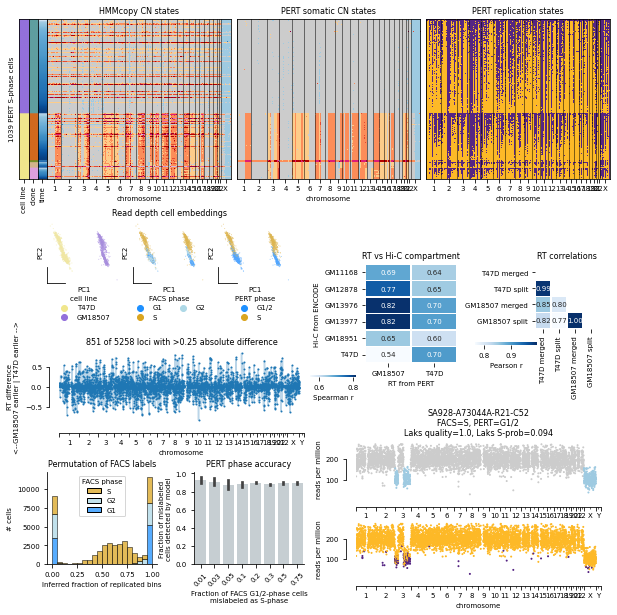

In [15]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 8.5/mult_factor))

# add three colorbars in the top-left corner to indicate which cells belong to which cell line, clone and time
ax0 = fig.add_axes([0.035, 0.7, 0.015, 0.26])
# ax0.set_title('ax0')
ax1 = fig.add_axes([0.05, 0.7, 0.015, 0.26])
# ax1.set_title('ax1')
ax2 = fig.add_axes([0.065, 0.7, 0.015, 0.26])
# ax2.set_title('ax2')

# add three heatmaps that represent the hmmcopy, PERT CN, and PERT replciation states
ax3 = fig.add_axes([0.08, 0.7, 0.3, 0.26])
# ax3.set_title('ax3')
ax4 = fig.add_axes([0.39, 0.7, 0.3, 0.26])
# ax4.set_title('ax4')
ax5 = fig.add_axes([0.7, 0.7, 0.3, 0.26])
# ax5.set_title('ax5')

# add a row of 3 small subplots underneath the left heatmaps to show the PCA cell embeddings
ax6 = fig.add_axes([0.08, 0.53, 0.12, 0.10])
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.22, 0.53, 0.12, 0.10])
# ax7.set_title('ax7')
ax8 = fig.add_axes([0.36, 0.53, 0.12, 0.10])
# ax8.set_title('ax8')

# show the difference between the two cell line RT profiles below the PCA embeddings
ax9 = fig.add_axes([0.1, 0.3, 0.4, 0.12])
# ax9.set_title('ax9')

# add two heatmaps to the right of the PCA embeddings that take up more vertical space
ax10 = fig.add_axes([0.6, 0.33, 0.15, 0.23])
# ax10.set_title('ax10')
ax11 = fig.add_axes([0.83, 0.41, 0.2, 0.15])
# ax11.set_title('ax11')

# add two subplots in the bottom left corner that show the results from the permuted label experiment
ax12 = fig.add_axes([0.08, 0.07, 0.18, 0.15])
# ax12.set_title('ax12')
ax13 = fig.add_axes([0.32, 0.07, 0.18, 0.15])
# ax13.set_title('ax13')

# add two cell profiles in the bottom right corner stacked on top of one another
ax14 = fig.add_axes([0.585, 0.18, 0.4, 0.09])
# ax14.set_title('ax14')
ax15 = fig.add_axes([0.585, 0.05, 0.4, 0.09])
# ax15.set_title('ax15')

# plot heatmaps for the hmmcopy, PERT CN, and PERT replication states in ax0-5
plot_cn_and_rep_states(
    cn_s, ax3, ax4, ax5, ax0, ax1, ax2
)

# plot the pca embeddings in ax6-8
plot_pca_embeddings(pca_df, ax6, ax7, ax8)

# plot the rt difference between the two cell lines in ax9
plot_rt_diff(rt_bulks, ax9)

# plot the hic vs rt correlations in ax10
plot_hic_rt_corr(corr_mat, ax10)

# plot the rt correlations in ax11
plot_rt_corr(rt_bulks, ax11)

# plot the permutation summary plots in ax12-13
permutation_summary_plots(legend_df, metrics_df, ax13, ax12)

# plot the cell profiles from a cell that is a likely FACS error based on PERT results in ax14-15
plot_facs_error(cn_g, ax14, ax15, s=1)

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# save the figure
plt.savefig('scdna_replication_paper/plots/laks_flow/main_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()